In [187]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.float_format', '{:.2f}'.format)

from sklearn.model_selection import train_test_split as tts   # el alias es cosa mia

from sklearn.ensemble import RandomForestRegressor as rfr

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler

pd.options.mode.copy_on_write = True

In [188]:
df = pd.read_csv("../NBA_csv/StatsAllTrain2.csv")

In [189]:
df[df["Player"]=="Nikola Jokic"]

,Player,Salario,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


In [190]:
#Eliminamos los drop del DataFrame original

df = df.dropna()

In [191]:
#Seleccionamos el salario por encima de 953 K que es el salario minimo de un jugador profesional.
df = df[df["Salario"]>=953000]

In [192]:
#vamos a convertir las stadisticas a minutos para que sea todo mas equitativo
def divide_by_G(df, columns):
    for column in columns:
        df[column] = df[column] / df['G']
    return df

columns_to_divide = ['PTS', '2P', '2PA', '3P', '3PA', 'FG', 'FGA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']
df = divide_by_G(df, columns_to_divide)


In [193]:
#Seleccionamos las columnas numericas para poder seguir.
df_numericas = df.select_dtypes(include=['number'])

#Eliminamos las columnas que no queremos utilizar.
df_numericas = df.drop(columns=["Player","STL","PF","BLK","TRB","eFG%","3P%","FG%","2P%","ORB","Pos","Tm","FT%"])

In [194]:
#Echamos un vistazo a las que tenemos.
df_numericas.head()

,Salario,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS
0,27739975,30,68,68,2316,8.19,15.43,0.13,0.51,8.06,14.91,5.60,6.63,4.87,5.59,2.41,22.12
1,26000000,34,53,53,1754,7.38,14.96,1.15,2.96,6.23,12.00,2.98,3.60,5.45,2.43,1.40,18.89
2,14000000,33,67,5,1461,3.97,8.90,1.10,3.28,2.87,5.61,1.79,2.03,4.49,1.70,1.31,10.84
3,12428571,31,66,1,1485,3.91,9.06,2.33,6.11,1.58,2.95,1.47,1.70,1.30,1.79,0.82,11.62
4,5846154,33,57,0,883,2.16,5.51,1.18,3.12,0.98,2.39,0.84,1.02,1.61,1.21,0.33,6.33


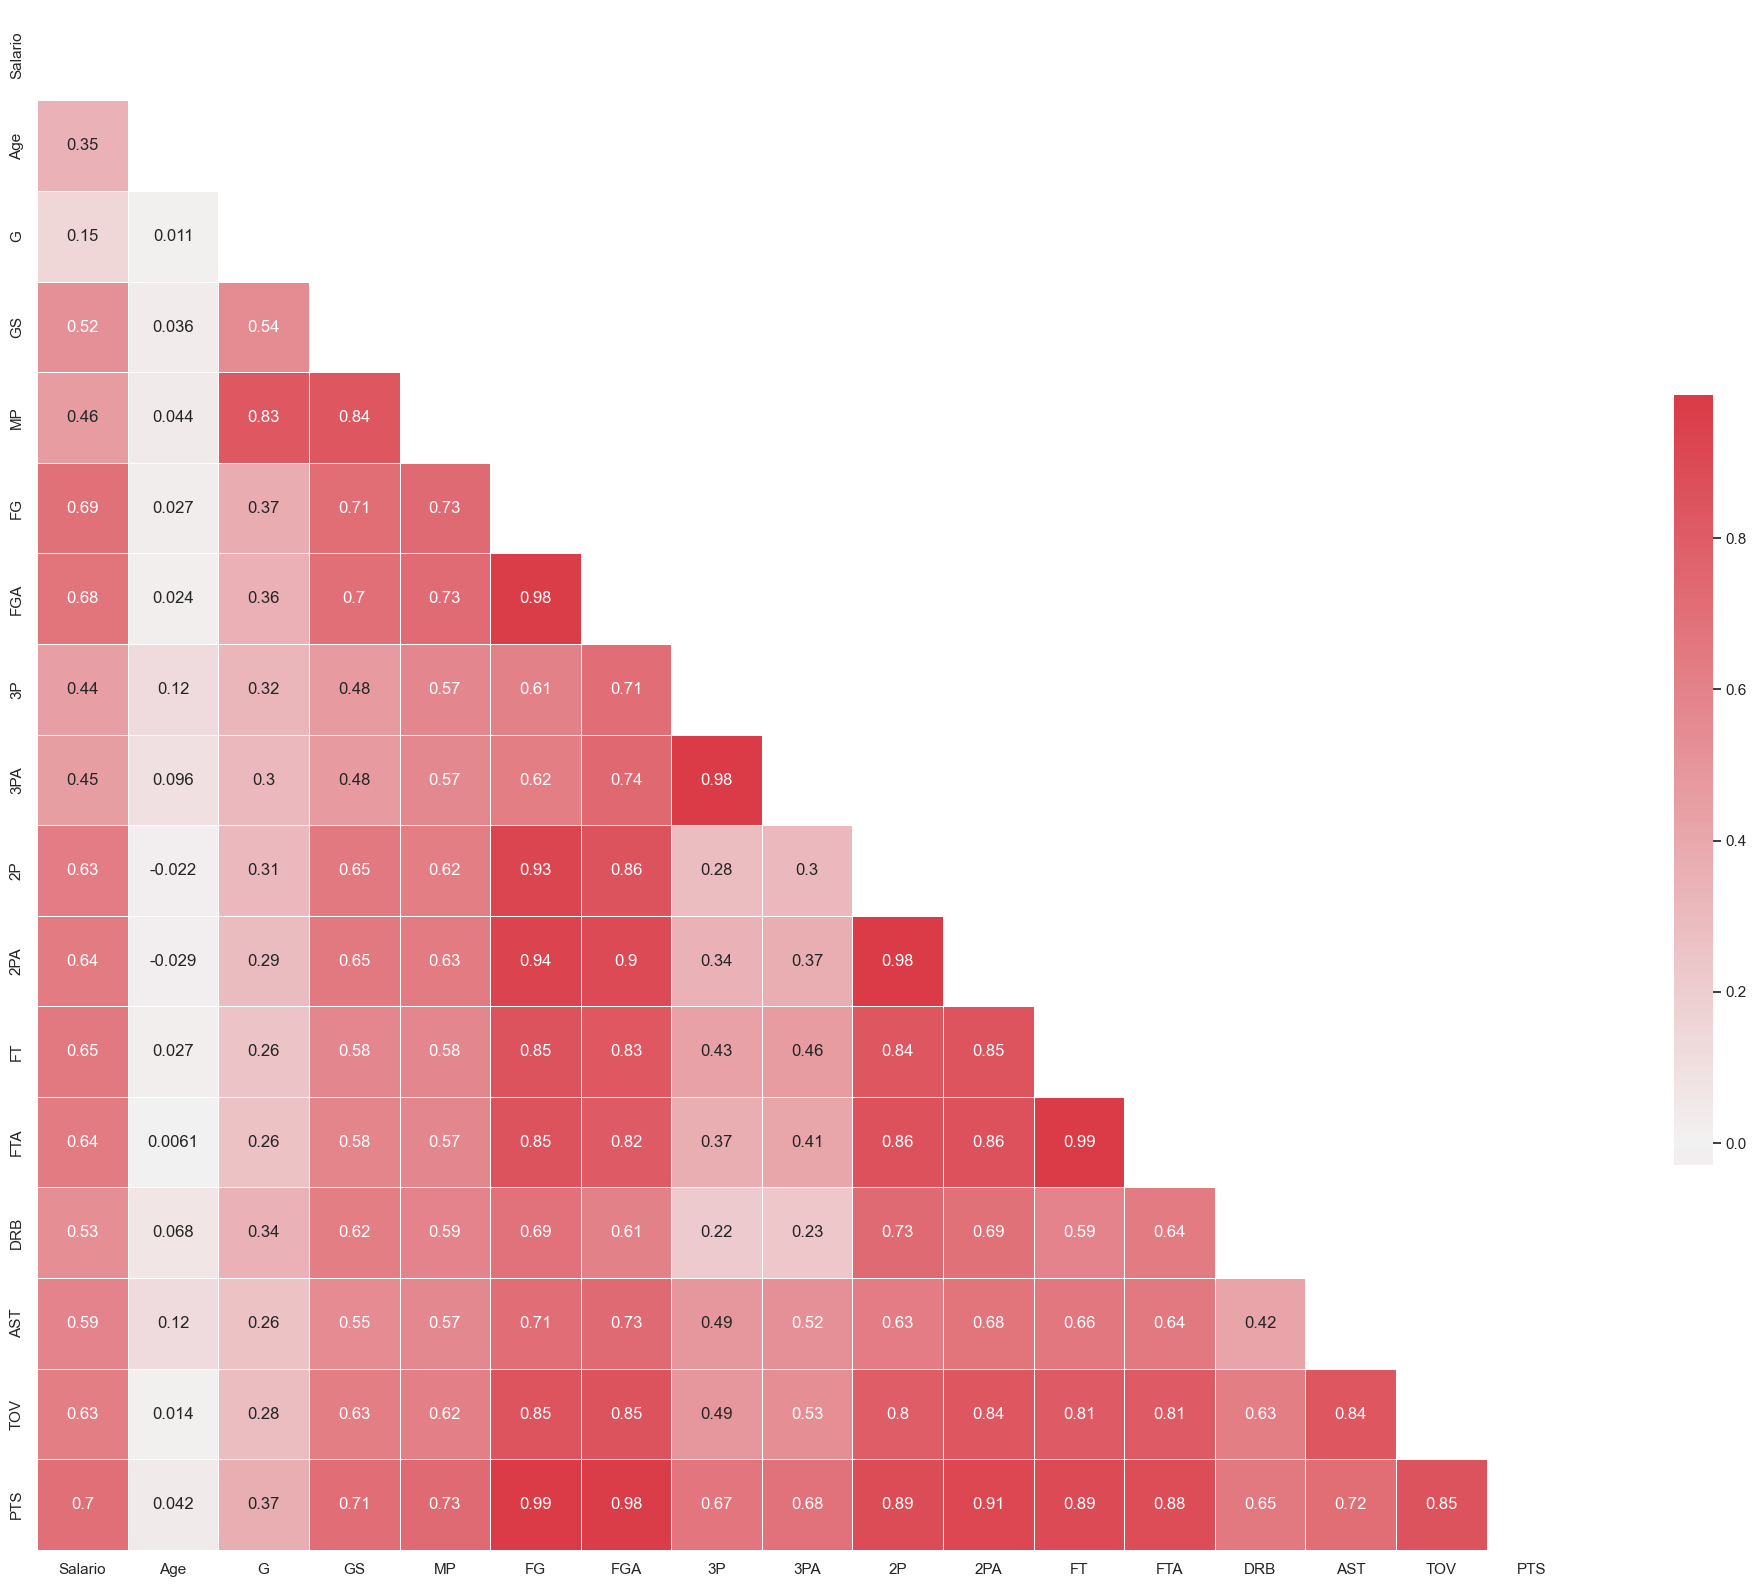

In [195]:
#tiramos un heatmap para ver la colinialidad de las Variables.

plt.figure(figsize=(25, 20))

sns.set(style='white')

mask=np.triu(np.ones_like(df_numericas.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(df_numericas.corr(),
           mask=mask,
           cmap=cmap,
           center=0,
           square=True,
           annot=True,
           linewidths=0.5,
           cbar_kws={'shrink': 0.5});

## Empezamos con el modelo de predicción

In [196]:
#Creamos las variables para entrenar el modelo. 
X = df_numericas.drop(columns="Salario")
 
y = df_numericas.Salario

X.head()

,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS
0,30,68,68,2316,8.19,15.43,0.13,0.51,8.06,14.91,5.60,6.63,4.87,5.59,2.41,22.12
1,34,53,53,1754,7.38,14.96,1.15,2.96,6.23,12.00,2.98,3.60,5.45,2.43,1.40,18.89
2,33,67,5,1461,3.97,8.90,1.10,3.28,2.87,5.61,1.79,2.03,4.49,1.70,1.31,10.84
3,31,66,1,1485,3.91,9.06,2.33,6.11,1.58,2.95,1.47,1.70,1.30,1.79,0.82,11.62
4,33,57,0,883,2.16,5.51,1.18,3.12,0.98,2.39,0.84,1.02,1.61,1.21,0.33,6.33


In [197]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [198]:
#triamos el Train Test Split para separar las filas en entreno y testeo.
X_tr, X_ts, y_train, y_test = tts(X, y,
                                       test_size=0.2,
                                       random_state=42
                                      )

X_tr.shape, X_ts.shape, y_train.shape, y_test.shape

((1567, 16), (392, 16), (1567,), (392,))

In [199]:
#Despues de ello normalizamos las variables para entrenarlas con nuestro modelo.
X_train = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)

X_test = pd.DataFrame(scaler.fit_transform(X_ts), columns=X_ts.columns)

In [200]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [201]:
X_train.shape

(1567, 16)

In [202]:
#Tiramos el modelo en mi caso un ExtraTreesRegressor el mejor valorado por Lazypredict.

exr  = ExtraTreesRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                    random_state=42)

# Entrenar el modelo final en el conjunto de entrenamiento completo
exr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = exr.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse_test)

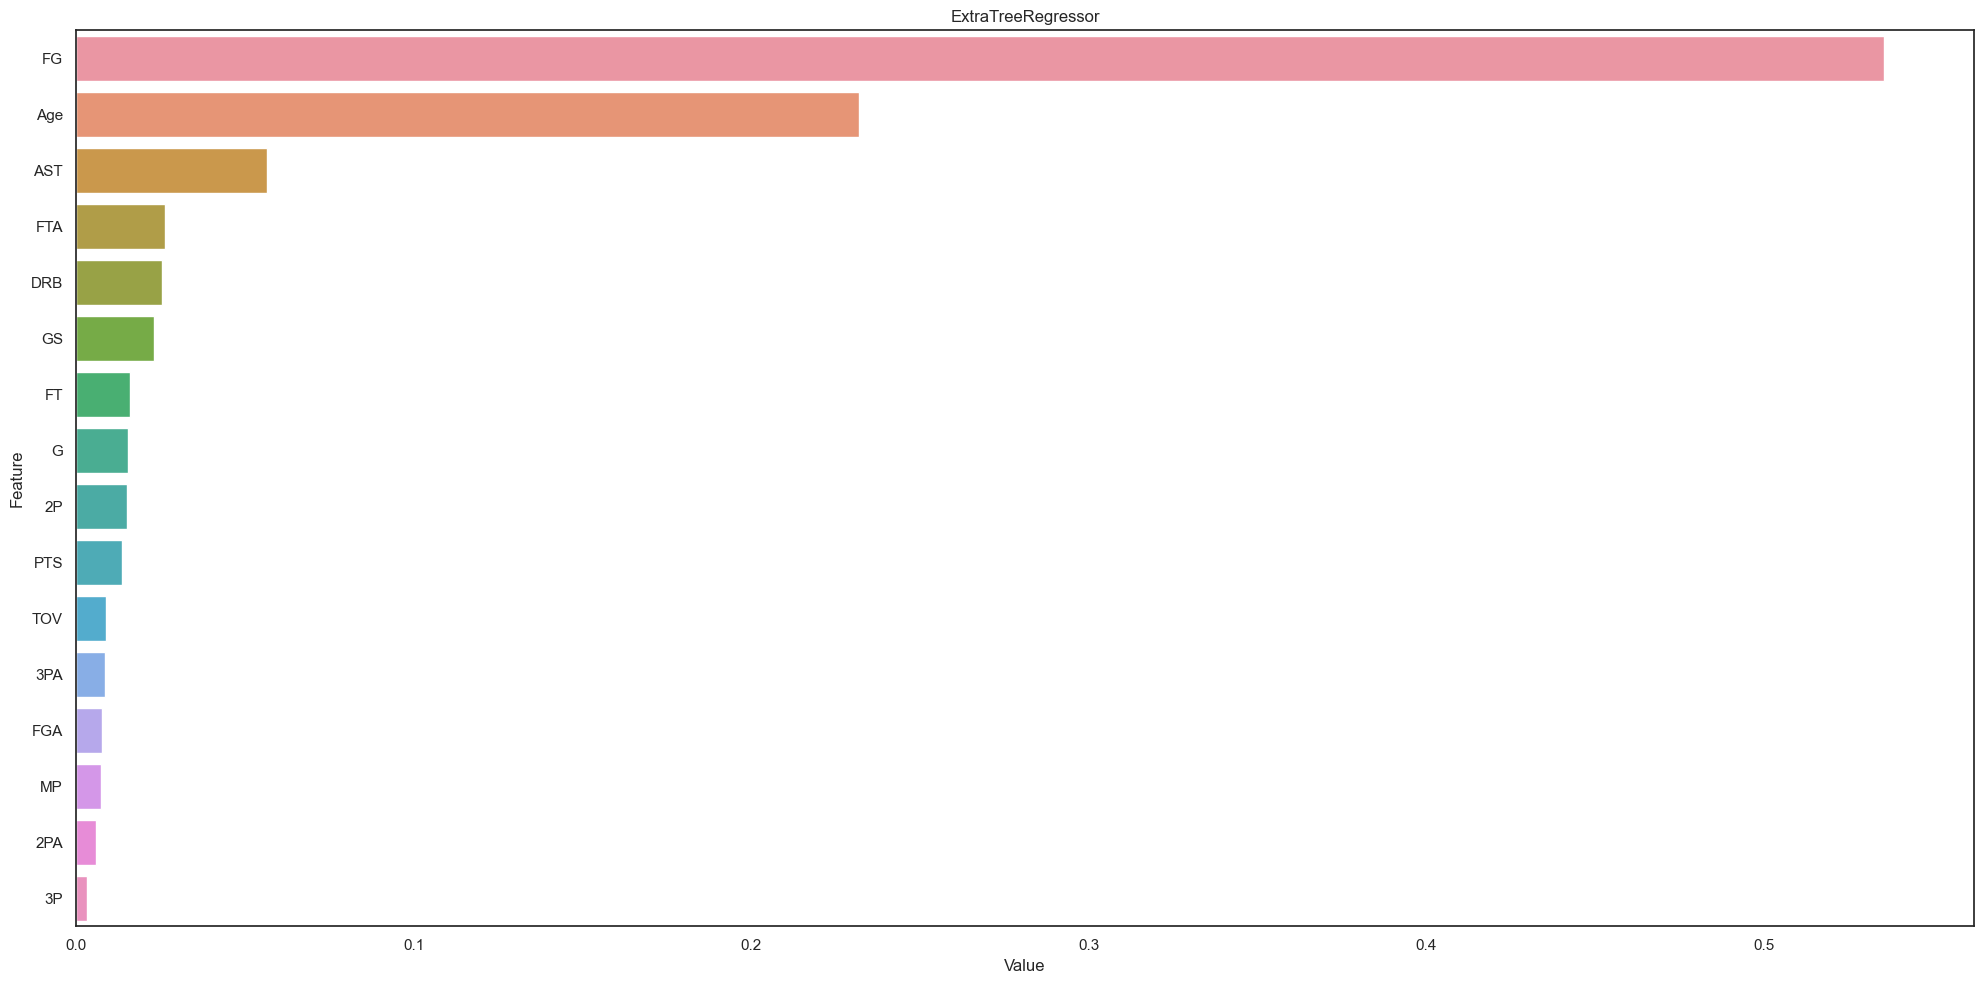

In [203]:
#Mostramos el feature importances, que nos dice la importancia de las variables que hemos entrenado.

feature_imp = pd.DataFrame(sorted(zip(exr[0].feature_importances_,X_train.columns)),
                           columns=['Value','Feature'])
plt.figure(figsize=(20, 10)),
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)),
plt.title('ExtraTreeRegressor')
plt.tight_layout()
plt.show()

In [204]:
#Mostramos el error cuadratico medio, que es el rango de valor en el que nos puede fallar.
rmse

4829287.747432122

In [205]:
#Cargamos el DataFrame donde vamos a aplicar el modelo para predecir el salario.

stats24_1 = pd.read_csv("stats_salary.csv")
salario_real = stats24_1.Salario

In [206]:
stats24_1[stats24_1.Player == "Nikola Jokić"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salario
207,Nikola Jokić,P,28,DEN,62,62,2120,634,1088,0.58,64,183,0.35,570,905,0.63,0.61,282,342,0.82,178,578,756,568,75,57,182,156,1614,47607350


In [207]:
#Eliminamos las mismas columnas que en el anterior dataFrame para que el modelo no nos de error.
stats24 = stats24_1.drop(columns=["PF","eFG%","3P%","FG%","2P%","FT%","ORB","TRB","BLK","STL"])

In [208]:
stats24.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Salario
0,Precious Achiuwa,P,24,TOT,56,17,1276,195,391,23,85,172,306,55,89,223,78,63,468,4379527
1,Bam Adebayo,P,26,MIA,53,53,1835,403,793,1,14,402,779,250,325,429,214,130,1057,32600060
2,Ochai Agbaji,ES,23,TOT,63,14,1208,132,323,56,177,76,146,24,32,109,57,44,344,4114200
3,Santi Aldama,AP,23,MEM,52,26,1334,210,485,89,255,121,230,42,69,228,115,63,551,2194200
4,Grayson Allen,ES,28,PHO,58,58,1949,250,505,154,328,96,177,100,113,191,179,75,754,8500000


In [209]:
#Llamamos a la funcion anterior para hacer el mismo progreso de dividir por Games pero esta vez sobre el dataFrame a predecir.

columns_to_divide_stats24 = ['PTS', '2P', '2PA', '3P', '3PA', 'FG', 'FGA', 'FT', 'FTA', 'DRB', 'AST', 'TOV']

df = divide_by_G(stats24, columns_to_divide_stats24)

In [210]:
#hacemos una coppia de los parametros para evitar una perdida de datos.
stats24_param = stats24.copy()

stats24_param.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Salario
0,Precious Achiuwa,P,24,TOT,56,17,1276,3.48,6.98,0.41,1.52,3.07,5.46,0.98,1.59,3.98,1.39,1.12,8.36,4379527
1,Bam Adebayo,P,26,MIA,53,53,1835,7.60,14.96,0.02,0.26,7.58,14.70,4.72,6.13,8.09,4.04,2.45,19.94,32600060
2,Ochai Agbaji,ES,23,TOT,63,14,1208,2.10,5.13,0.89,2.81,1.21,2.32,0.38,0.51,1.73,0.90,0.70,5.46,4114200
3,Santi Aldama,AP,23,MEM,52,26,1334,4.04,9.33,1.71,4.90,2.33,4.42,0.81,1.33,4.38,2.21,1.21,10.60,2194200
4,Grayson Allen,ES,28,PHO,58,58,1949,4.31,8.71,2.66,5.66,1.66,3.05,1.72,1.95,3.29,3.09,1.29,13.00,8500000


In [211]:
stats24.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Salario
0,Precious Achiuwa,P,24,TOT,56,17,1276,3.48,6.98,0.41,1.52,3.07,5.46,0.98,1.59,3.98,1.39,1.12,8.36,4379527
1,Bam Adebayo,P,26,MIA,53,53,1835,7.60,14.96,0.02,0.26,7.58,14.70,4.72,6.13,8.09,4.04,2.45,19.94,32600060
2,Ochai Agbaji,ES,23,TOT,63,14,1208,2.10,5.13,0.89,2.81,1.21,2.32,0.38,0.51,1.73,0.90,0.70,5.46,4114200
3,Santi Aldama,AP,23,MEM,52,26,1334,4.04,9.33,1.71,4.90,2.33,4.42,0.81,1.33,4.38,2.21,1.21,10.60,2194200
4,Grayson Allen,ES,28,PHO,58,58,1949,4.31,8.71,2.66,5.66,1.66,3.05,1.72,1.95,3.29,3.09,1.29,13.00,8500000


In [212]:
# Normalizamos a la a grosso modo para ir comprobando que todo funciona

stats24["Age"]=(stats24["Age"]-np.mean(stats24["Age"]))/np.std(stats24["Age"])
stats24["G"]=(stats24["G"]-np.mean(stats24["G"]))/np.std(stats24["G"])
stats24["GS"]=(stats24["GS"]-np.mean(stats24["GS"]))/np.std(stats24["GS"])
stats24["MP"]=(stats24["MP"]-np.mean(stats24["MP"]))/np.std(stats24["MP"])
stats24["FG"]=(stats24["FG"]-np.mean(stats24["FG"]))/np.std(stats24["FG"])
stats24["FGA"]=(stats24["FGA"]-np.mean(stats24["FGA"]))/np.std(stats24["FGA"])
stats24["3P"]=(stats24["3P"]-np.mean(stats24["3P"]))/np.std(stats24["3P"])
stats24["3PA"]=(stats24["3PA"]-np.mean(stats24["3PA"]))/np.std(stats24["3PA"])
stats24["2P"]=(stats24["2P"]-np.mean(stats24["2P"]))/np.std(stats24["2P"])
stats24["2PA"]=(stats24["2PA"]-np.mean(stats24["2PA"]))/np.std(stats24["2PA"])
stats24["FT"]=(stats24["FT"]-np.mean(stats24["FT"]))/np.std(stats24["FT"])
stats24["FTA"]=(stats24["FTA"]-np.mean(stats24["FTA"]))/np.std(stats24["FTA"])
stats24["DRB"]=(stats24["DRB"]-np.mean(stats24["DRB"]))/np.std(stats24["DRB"])
stats24["AST"]=(stats24["AST"]-np.mean(stats24["AST"]))/np.std(stats24["AST"])
stats24["TOV"]=(stats24["TOV"]-np.mean(stats24["TOV"]))/np.std(stats24["TOV"])
stats24["PTS"]=(stats24["PTS"]-np.mean(stats24["PTS"]))/np.std(stats24["PTS"])

In [213]:
#volvemos al proceso de realizar el modelo.

stats24_salario = stats24.Salario

stats = stats24.drop(columns=["Salario"])

# Elimina la columna 'Tm' y almacénala en otra variable
tm_column = stats.pop('Tm')

# Inserta la columna 'Tm' en la segunda posición del DataFrame
stats.insert(1, 'Tm', tm_column)

In [214]:
#Comprobamos los nan que tenemos.
stats.isna().sum()
stats["Pos"].fillna("BA")

0       P
1       P
2      ES
3      AP
4      ES
5       P
6      BA
7      AP
8      BA
9      AL
10     BA
11     AL
12      P
13      P
14     AL
15     BA
16      P
17     AP
18     ES
19     BA
20     AP
21     AP
22     ES
23     ES
24      P
25     AL
26     AP
27     AP
28     ES
29     ES
30     AL
31     BA
32     AL
33      P
34     ES
35      P
36     BA
37     AP
38      P
39     BA
40     AP
41     ES
42     BA
43     BA
44     ES
45     AL
46     AL
47     AL
48     BA
49     BA
50     BA
51     AL
52     ES
53     AL
54     AP
55      P
56     BA
57      P
58     ES
59     AL
60     ES
61     AP
62     AP
63      P
64     BA
65      P
66     ES
67     ES
68     AL
69     ES
70     AL
71     ES
72     AP
73     AL
74     AP
75      P
76     BA
77     AL
78     AL
79     BA
80     AL
81     AP
82     BA
83     BA
84     ES
85     BA
86     BA
87      P
88     ES
89     ES
90     AL
91     AP
92     ES
93     ES
94     AP
95     BA
96     ES
97     BA
98     AL
99     ES


In [215]:
# Realizar predicciones en el conjunto de prueba
y_pred = exr.predict(stats.iloc[:,3:])
y_pred

array([ 4830726.27046391, 26286284.01636133,  3226214.13617449,
        5816237.92425257, 12590597.24779558, 21170726.90591152,
        4123159.15628405,  7659400.97322334,  6168185.01174751,
       16133640.22310641,  4043319.93700289, 11159059.50605765,
       23666896.50285489, 10474919.13394928,  2690640.62768208,
       12644817.98717307,  3300637.02242959,  9530077.89419491,
       24521271.17160219,  3390523.80634682,  3177381.34622773,
       14381160.65586003,  9543995.5929144 , 14733772.46268079,
        3035965.2881614 ,  4951705.82836754,  7974186.49882745,
        2098041.99883028, 31844349.46076341,  9442524.48456752,
        2910669.44142207,  8099682.87036498, 10331968.01854445,
        3666423.71944544,  2684231.90565933,  8256818.13167028,
        3548921.98966176,  3588320.61044182,  2428904.36855991,
       31739478.06707512,  6697644.14999413,  2574151.74990354,
        3904964.29715715,  4570254.13654213,  3283646.62353977,
       23668317.91026142, 18019390.09990

In [216]:
#pasamos a dataframe el modelo predictivo para poder unirlo al DataFrame original.

stats["Predict_salario"] = pd.DataFrame(y_pred)

stats["Real_salario"] = stats24_salario

In [217]:
#Duplicamos para evitar una perdida de datos.
dupli_stats = stats.copy()

dupli_stats.head()

,Player,Tm,Pos,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Predict_salario,Real_salario
0,Precious Achiuwa,TOT,P,-0.45,0.79,-0.14,0.48,0.03,-0.06,-0.68,-0.58,0.34,0.29,-0.28,-0.11,0.70,-0.41,0.07,-0.13,4830726.27,4379527
1,Bam Adebayo,MIA,P,0.01,0.62,1.48,1.33,1.66,1.49,-1.11,-1.12,2.60,2.84,2.28,2.48,2.96,0.93,1.71,1.52,26286284.02,32600060
2,Ochai Agbaji,TOT,ES,-0.68,1.16,-0.27,0.38,-0.52,-0.42,-0.16,-0.03,-0.59,-0.58,-0.69,-0.72,-0.54,-0.66,-0.46,-0.54,3226214.14,4114200
3,Santi Aldama,MEM,AP,-0.68,0.57,0.27,0.57,0.25,0.40,0.74,0.87,-0.03,0.00,-0.40,-0.26,0.92,0.00,0.18,0.19,5816237.92,2194200
4,Grayson Allen,PHO,ES,0.46,0.89,1.71,1.50,0.35,0.28,1.77,1.19,-0.36,-0.38,0.23,0.10,0.32,0.45,0.28,0.53,12590597.25,8500000


In [218]:
# Lista de columnas a desnormalizar
columns_to_desnormalize = ["Age", "G", "GS", "MP", "FG", "FGA", "3P", "3PA", "2P", "2PA",
                            "FT", "FTA", "DRB", "AST", "TOV", "PTS"]

# Desnormalizar cada columna
for column in columns_to_desnormalize:
    stats[column] = (stats[column] * np.std(stats24_param[column])) + np.mean(stats24_param[column])

In [219]:
stats.head()

,Player,Tm,Pos,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Predict_salario,Real_salario
0,Precious Achiuwa,TOT,P,24.00,56.00,17.00,1276.00,3.48,6.98,0.41,1.52,3.07,5.46,0.98,1.59,3.98,1.39,1.12,8.36,4830726.27,4379527
1,Bam Adebayo,MIA,P,26.00,53.00,53.00,1835.00,7.60,14.96,0.02,0.26,7.58,14.70,4.72,6.13,8.09,4.04,2.45,19.94,26286284.02,32600060
2,Ochai Agbaji,TOT,ES,23.00,63.00,14.00,1208.00,2.10,5.13,0.89,2.81,1.21,2.32,0.38,0.51,1.73,0.90,0.70,5.46,3226214.14,4114200
3,Santi Aldama,MEM,AP,23.00,52.00,26.00,1334.00,4.04,9.33,1.71,4.90,2.33,4.42,0.81,1.33,4.38,2.21,1.21,10.60,5816237.92,2194200
4,Grayson Allen,PHO,ES,28.00,58.00,58.00,1949.00,4.31,8.71,2.66,5.66,1.66,3.05,1.72,1.95,3.29,3.09,1.29,13.00,12590597.25,8500000


In [220]:
#Sacamos el porcentaje de la diferencia de salarios para tener mas datos.
stats["Diferencia_%"] = ((stats["Real_salario"] - stats["Predict_salario"] ) / stats["Real_salario"]) *100

In [221]:
#Buscamos NaN que podamos tener y lo rellenamos con la mediana.
stats = stats.fillna(stats.Predict_salario.median())

In [222]:
#Pasamos todos nuestros datos numericos para poder tener un manejo mejor en el Dashboard y tener mas claridad.
stats.Age = stats.Age.astype(int)
stats.G = stats.G.astype(int)
stats.GS= stats.GS.astype(int)
stats.MP= stats.MP.astype(int)
stats.FG= stats.FG.astype(int)
stats.FGA= stats.FGA.astype(int)
stats["3P"]= stats["3P"].astype(int)
stats["3PA"]= stats["3PA"].astype(int)
stats["2P"]= stats["2P"].astype(int)
stats["2PA"]= stats["2PA"].astype(int)
stats.FT= stats.FT.astype(int)
stats.FTA= stats.FTA.astype(int)
stats.DRB= stats.DRB.astype(int)
stats.AST= stats.AST.astype(int)
stats.TOV= stats.TOV.astype(int)
stats.PTS= stats.PTS.astype(int)
stats.Predict_salario= stats.Predict_salario.astype(int)

In [223]:
#Pasamos la diferencia a String ya que en powerBI no reconoce la , y no deja manejar el valor.

stats["Diferencia_%"] = stats["Diferencia_%"].astype(str)

stats["Diferencia_%"]=stats["Diferencia_%"].str.replace(".",",")

In [224]:
#Diccionario para introducir las imagenes de los equipos para POWERBI
nba_teams = {
    'ATL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/ATL-2024.png",
    'BOS': "https://cdn.ssref.net/req/202312151/tlogo/bbr/BOS-2024.png",
    'BRK': "https://cdn.ssref.net/req/202312151/tlogo/bbr/BRK-2024.png",
    'CHO': "https://cdn.ssref.net/req/202312151/tlogo/bbr/CHO-2024.png",
    'CHI': "https://cdn.ssref.net/req/202312151/tlogo/bbr/CHI-2024.png",
    'CLE': "https://cdn.ssref.net/req/202312151/tlogo/bbr/CLE-2024.png",
    'DAL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/DAL-2024.png",
    'DEN': "https://cdn.ssref.net/req/202312151/tlogo/bbr/DEN-2024.png",
    'DET': "https://cdn.ssref.net/req/202312151/tlogo/bbr/DET-2024.png",
    'GSW': "https://cdn.ssref.net/req/202312151/tlogo/bbr/GSW-2024.png",
    'HOU': "https://cdn.ssref.net/req/202312151/tlogo/bbr/HOU-2024.png",
    'IND': "https://cdn.ssref.net/req/202312151/tlogo/bbr/IND-2024.png",
    'LAC': "https://cdn.ssref.net/req/202312151/tlogo/bbr/LAC-2024.png",
    'LAL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/LAL-2024.png",
    'MEM': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MEM-2024.png",
    'MIA': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MIA-2024.png",
    'MIL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MIL-2024.png",
    'MIN': "https://cdn.ssref.net/req/202312151/tlogo/bbr/MIN-2024.png",
    'NOP': "https://cdn.ssref.net/req/202312151/tlogo/bbr/NOP-2024.png",
    'NYK': "https://cdn.ssref.net/req/202312151/tlogo/bbr/NYK-2024.png",
    'OKC': "https://cdn.ssref.net/req/202312151/tlogo/bbr/OKC-2024.png",
    'ORL': "https://cdn.ssref.net/req/202312151/tlogo/bbr/ORL-2024.png",
    'PHI': "https://cdn.ssref.net/req/202312151/tlogo/bbr/PHI-2024.png",
    'PHO': "https://cdn.ssref.net/req/202312151/tlogo/bbr/PHO-2024.png",
    'POR': "https://cdn.ssref.net/req/202312151/tlogo/bbr/POR-2024.png",
    'SAC': "https://cdn.ssref.net/req/202312151/tlogo/bbr/SAC-2024.png",
    'SAS': "https://cdn.ssref.net/req/202312151/tlogo/bbr/SAS-2024.png",
    'TOR': "https://cdn.ssref.net/req/202312151/tlogo/bbr/TOR-2024.png",
    'UTA': "https://cdn.ssref.net/req/202312151/tlogo/bbr/UTA-2024.png",
    'WAS': "https://cdn.ssref.net/req/202312151/tlogo/bbr/WAS-2024.png"
}


In [225]:
stats['Image_URL'] = stats['Tm'].map(nba_teams)

In [226]:
# Diccionario para cambiar el nombre de los equipos de siglas a su nombre completo.
nba_names = {
    'ATL': "Atlanta Hawks",
    'BOS': "Boston Celtics",
    'BRK': "Brooklyn Nets",
    'CHO': "Charlotte Hornets",
    'CHI': "Chicago Bulls",
    'CLE': "Cleveland Cavaliers",
    'DAL': "Dallas Mavericks",
    'DEN': "Denver Nuggets",
    'DET': "Detroit Pistons",
    'GSW': "Golden State Warriors",
    'HOU': "Houston Rockets",
    'IND': "Indiana Pacers",
    'LAC': "Los Angeles Clippers",
    'LAL': "Los Angeles Lakers",
    'MEM': "Memphis Grizzlies",
    'MIA': "Miami Heat",
    'MIL': "Milwaukee Bucks",
    'MIN': "Minnesota Timberwolves",
    'NOP': "New Orleans Pelicans",
    'NYK': "New York Knicks",
    'OKC': "Oklahoma City Thunder",
    'ORL': "Orlando Magic",
    'PHI': "Philadelphia 76ers",
    'PHO': "Phoenix Suns",
    'POR': "Portland Trail Blazers",
    'SAC': "Sacramento Kings",
    'SAS': "San Antonio Spurs",
    'TOR': "Toronto Raptors",
    'UTA': "Utah Jazz",
    'WAS': "Washington Wizards"
}

In [227]:
#Hacemos el metodo replace para sobrescribrirlo
stats["Tm"] = stats["Tm"].replace(nba_names)

In [228]:
stats.head()

,Player,Tm,Pos,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Predict_salario,Real_salario,Diferencia_%,Image_URL
0,Precious Achiuwa,TOT,P,24,56,17,1276,3,6,0,1,3,5,0,1,3,1,1,8,4830726,4379527,"-10,302465779156222",NaN
1,Bam Adebayo,Miami Heat,P,26,53,53,1835,7,14,0,0,7,14,4,6,8,4,2,19,26286284,32600060,"19,367375347280547",https://cdn.ssref.net/req/202312151/tlogo/bbr/...
2,Ochai Agbaji,TOT,ES,23,63,14,1208,2,5,0,2,1,2,0,0,1,0,0,5,3226214,4114200,"21,583439400746414",NaN
3,Santi Aldama,Memphis Grizzlies,AP,23,52,26,1334,4,9,1,4,2,4,0,1,4,2,1,10,5816237,2194200,"-165,0732806604943",https://cdn.ssref.net/req/202312151/tlogo/bbr/...
4,Grayson Allen,Phoenix Suns,ES,28,58,58,1949,4,8,2,5,1,3,1,1,3,3,1,13,12590597,8500000,"-48,12467350347737",https://cdn.ssref.net/req/202312151/tlogo/bbr/...


In [229]:
#Guardamos el csv para llevarlo a PowerBI
stats.to_csv("statsOficial.csv", index = False)

In [230]:
stats[stats["Player"]=="Luka Dončić"]

,Player,Tm,Pos,Age,G,GS,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,DRB,AST,TOV,PTS,Predict_salario,Real_salario,Diferencia_%,Image_URL
97,Luka Dončić,Dallas Mavericks,BA,24,56,56,2104,11,23,3,10,7,13,7,9,8,9,3,34,30846528,40064220,"23,007289867830462",https://cdn.ssref.net/req/202312151/tlogo/bbr/...


# Gracias por llegar hasta aquí y dar valor al codigo. :D 